# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.to_excel(xl_writer, "raw")

In [7]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [8]:
df.head()

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,NaN,Albania,0,0,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,NaN,Angola,0,0,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


In [9]:
countries = df["Country/Region"].unique()

In [10]:
countries.sort()

In [11]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [12]:
province = df["Province/State"]

In [13]:
province.dropna(inplace=True)

In [14]:
province = province.unique()

In [15]:
province.sort()

In [16]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [17]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)

        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [18]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        df.plot(logy=logy, **kwargs)
    plt.show()
            

# Switzerland

In [19]:
swiss = extract_data(df, "Switzerland")

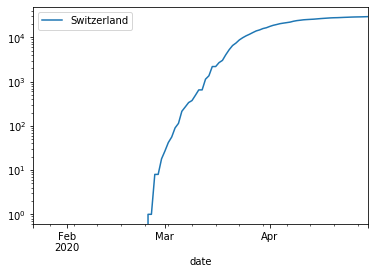

In [20]:
plot_data(swiss, logy=True)

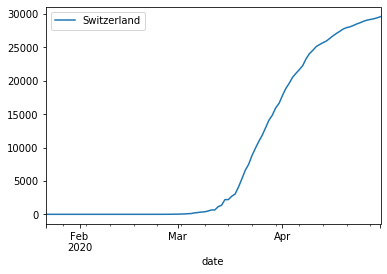

In [21]:
plot_data(swiss)

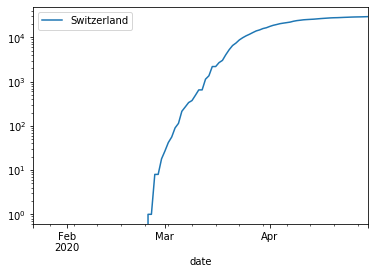

In [22]:
plot_data(swiss, logy=True)

# Europe

In [23]:
italy = extract_data(df, "Italy")

In [24]:
france = extract_data(df, "France")

In [25]:
uk = extract_data(df, "United Kingdom")

In [26]:
spain = extract_data(df, "Spain")

In [27]:
germany =  extract_data(df, "Germany")

In [28]:
austria =  extract_data(df, "Austria")

In [29]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [30]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [31]:
europe

,,Switzerland,Italy,France,Germany,Austria,Spain,United Kingdom
date,day_of_year,,,,,,,
2020-01-22,22,0,0,0,0,0,0,0
2020-01-23,23,0,0,0,0,0,0,0
2020-01-24,24,0,0,2,0,0,0,0
2020-01-25,25,0,0,3,0,0,0,0
2020-01-26,26,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-04-26,117,29061,197675,160847,157770,15225,207634,152840
2020-04-27,118,29164,199414,164589,158758,15274,209465,157149
2020-04-28,119,29264,201505,167605,159912,15357,210773,161145


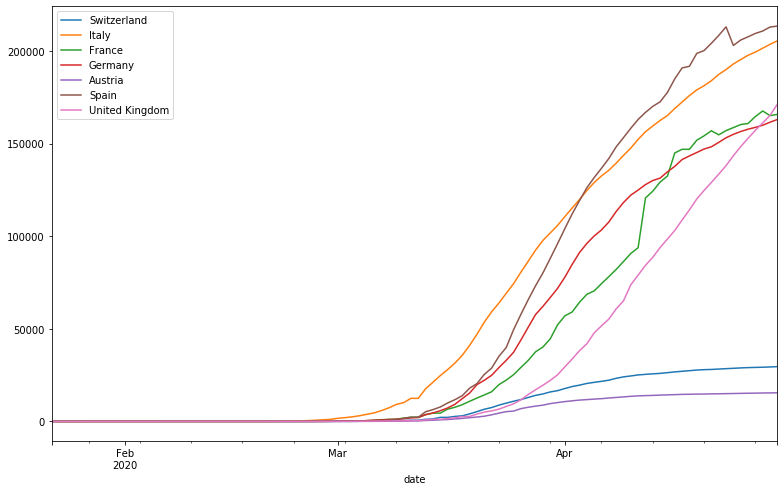

In [32]:
plot_data(europe, figsize=(13, 8))

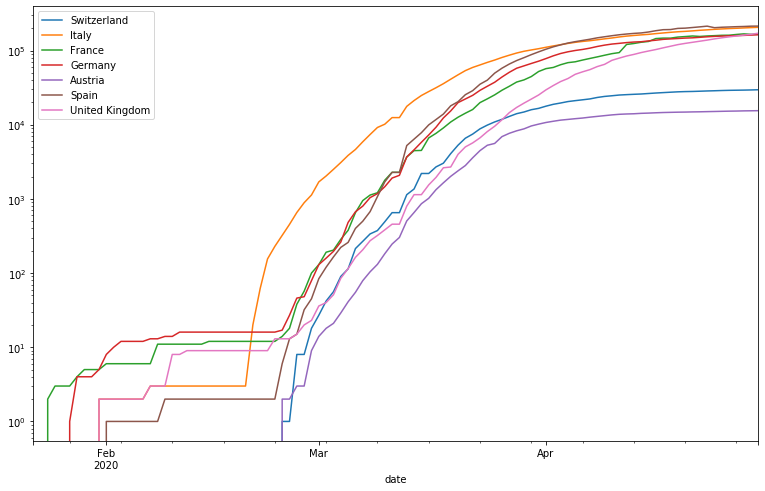

In [33]:
plot_data(europe, logy=True, figsize=(13, 8))

# USA

In [34]:
us = extract_data(df, country="US", groupby=True)

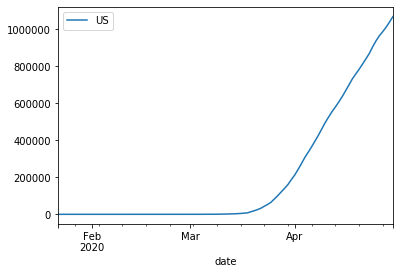

In [35]:
plot_data(us)

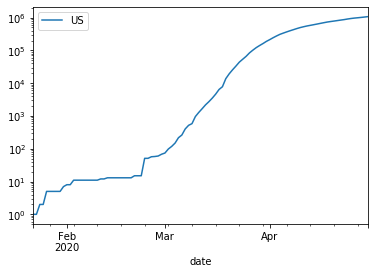

In [36]:
plot_data(us, logy=True)

# Europe + USA

In [37]:
comp_us = pd.concat([europe, us], axis=1)

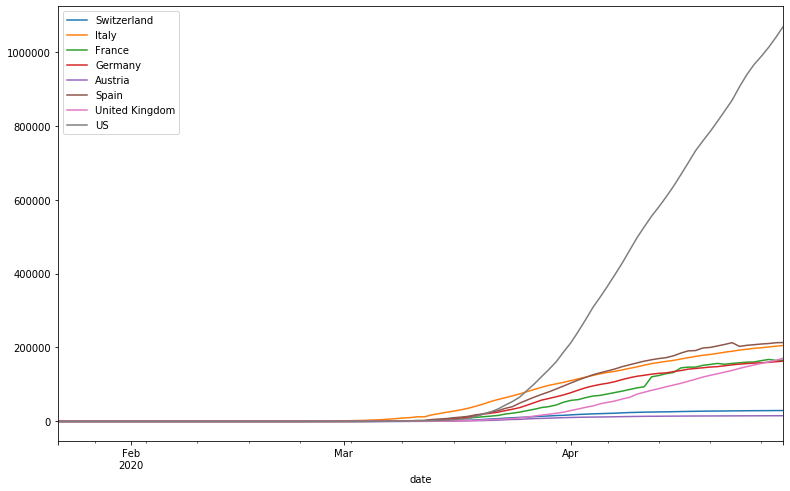

In [38]:
plot_data(comp_us, figsize=(13, 8))

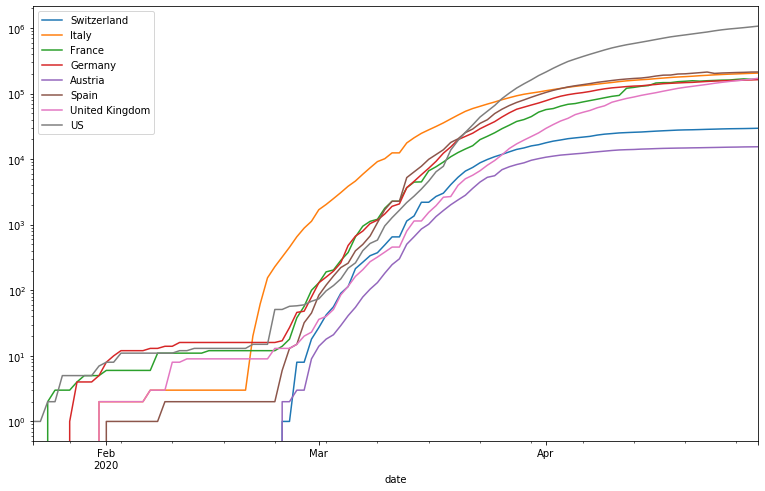

In [39]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [40]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [41]:
world.index = pd.to_datetime(world.index)

In [42]:
world["day_of_year"] = world.index.dayofyear

In [43]:
world.reset_index(inplace=True)

In [44]:
world.columns = ["date", "world_cases", "day_of_year"]

In [45]:
world.set_index(["date", "day_of_year"], inplace=True)

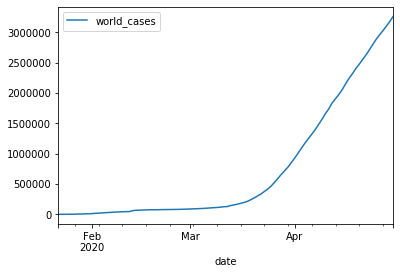

In [46]:
plot_data(world)

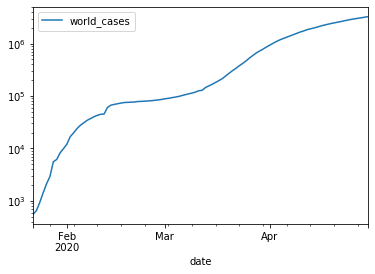

In [47]:
plot_data(world, logy=True)

# Iran

In [48]:
iran = extract_data(df, "Iran")

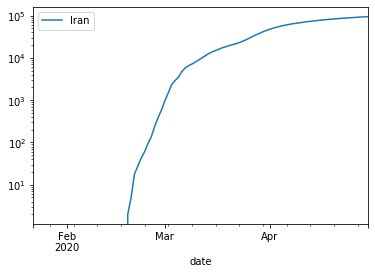

In [49]:
plot_data(iran, logy=True)

In [50]:
comp_iran = pd.concat([comp_us, iran], axis=1)

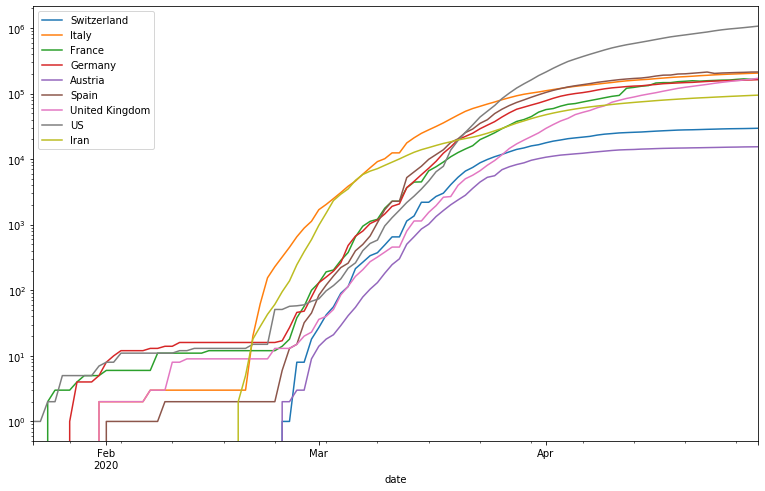

In [51]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [52]:
china = extract_data(df, "China", groupby=True)

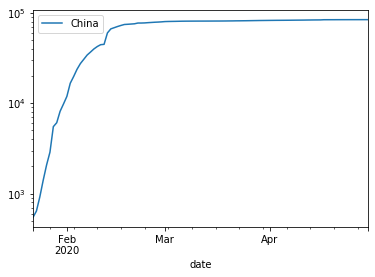

In [53]:
plot_data(china, logy=True)

In [54]:
comp_china = pd.concat([china, comp_us], axis=1)

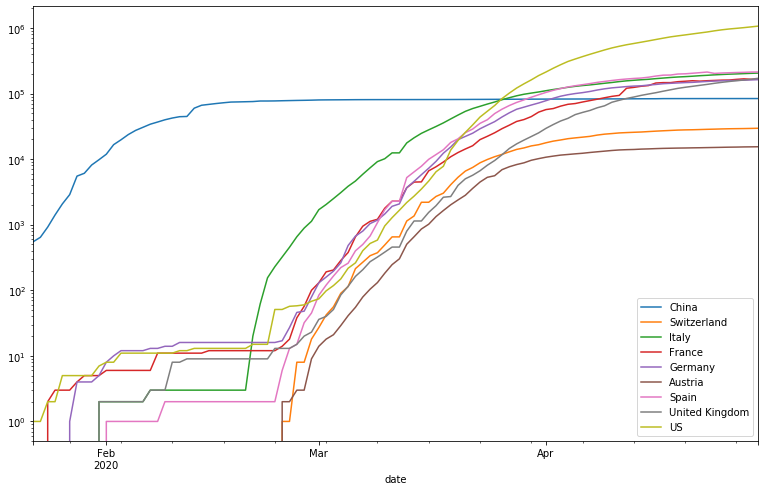

In [55]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [56]:
shanghai = extract_data(df, "China", "Shanghai")

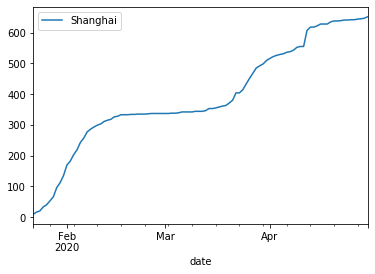

In [57]:
plot_data(shanghai)

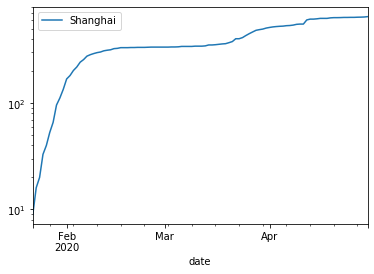

In [58]:
plot_data(shanghai, logy=True)

# Singapore

In [59]:
singapore = extract_data(df, "Singapore")

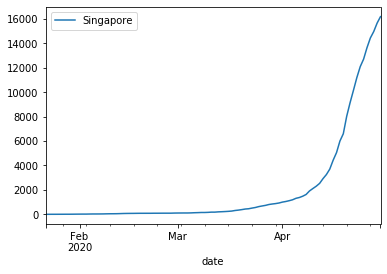

In [60]:
plot_data(singapore)

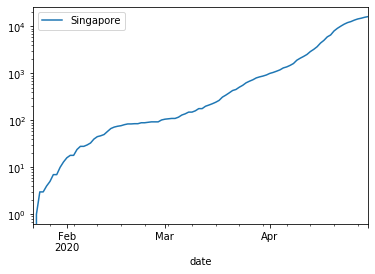

In [61]:
plot_data(singapore, logy=True)

# South Korea

In [62]:
kr = extract_data(df, "Korea, South")

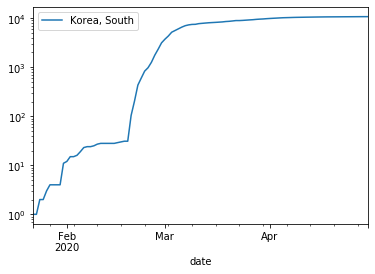

In [63]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [64]:
hong_kong = extract_data(df,"China", "Hong Kong")

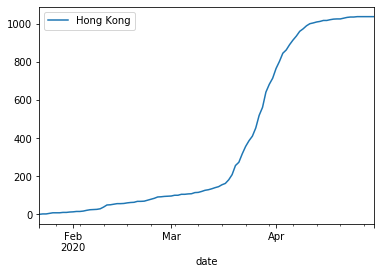

In [65]:
plot_data(hong_kong)

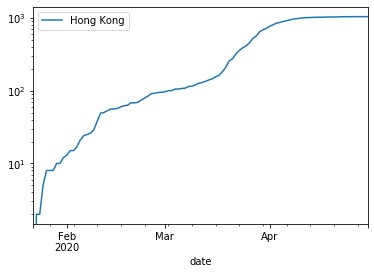

In [66]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [67]:
hubei = extract_data(df,"China", "Hubei")

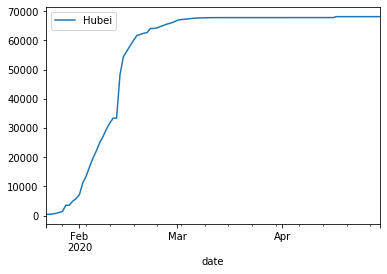

In [68]:
plot_data(hubei)

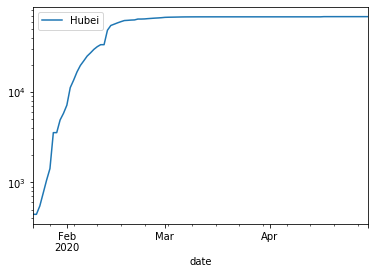

In [69]:
plot_data(hubei, logy=True)

## Henan

In [70]:
henan = extract_data(df, "China", "Henan")

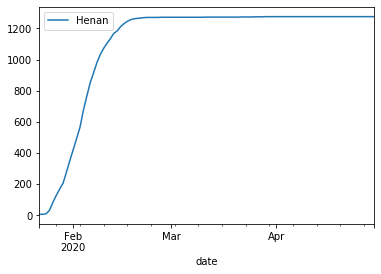

In [71]:
plot_data(henan)

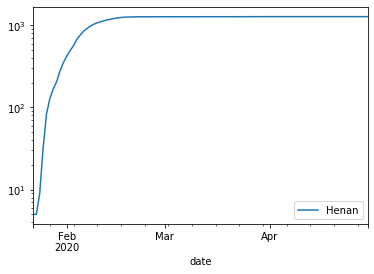

In [72]:
plot_data(henan, logy=True)

## Hunan

In [73]:
hunan = extract_data(df, "China", "Hunan")

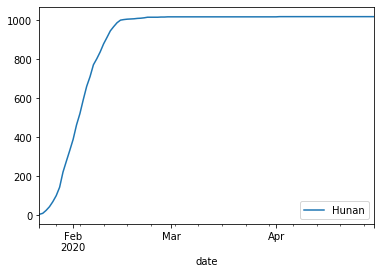

In [74]:
plot_data(hunan)

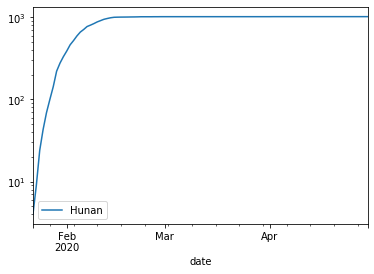

In [75]:
plot_data(hunan, logy=True)

## Guangdong

In [76]:
guangdong = extract_data(df, "China", "Guangdong")

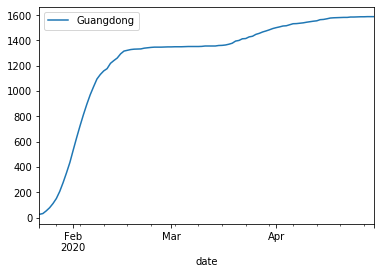

In [77]:
plot_data(guangdong)

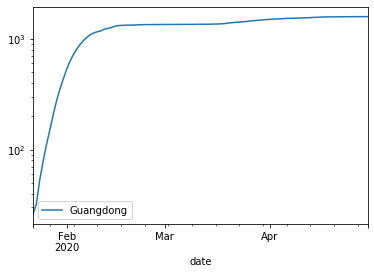

In [78]:
plot_data(guangdong, logy=True)

## Guangxi

In [79]:
guangxi = extract_data(df, "China", "Guangxi")

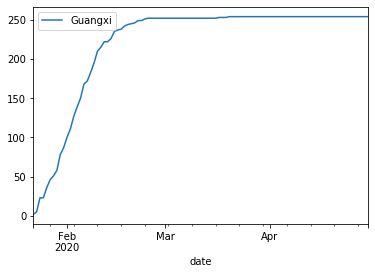

In [80]:
plot_data(guangxi)

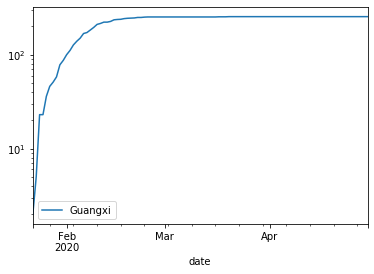

In [81]:
plot_data(guangxi, logy=True)

# South-Asia

In [82]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

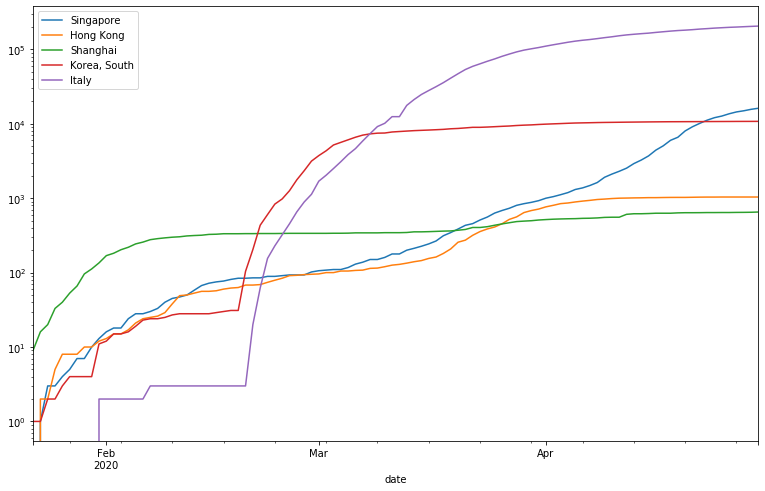

In [83]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [84]:
sweden = extract_data(df, "Sweden")

In [85]:
norway = extract_data(df, "Norway")

In [86]:
danemark = extract_data(df, 'Danemark')

In [87]:
finland = extract_data(df, 'Finland')

In [88]:
nl = extract_data(df, "Netherlands")

In [89]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

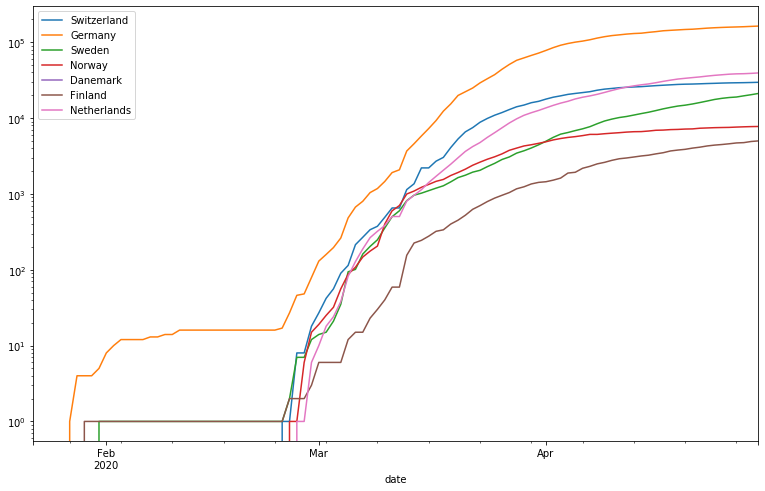

In [90]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [91]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [92]:
death = pd.read_csv(url)

In [93]:
death.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,36,40,42,43,47,50,57,58,60,64
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,27,27,27,27,28,28,30,30,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,392,402,407,415,419,425,432,437,444,450
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,37,37,37,40,40,40,40,41,42,42
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [94]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [95]:
uk_death = extract_data(death, "United Kingdom")

In [96]:
us_death = extract_data(death, "US", groupby=True)

In [97]:
it_death = extract_data(death, "Italy")

In [98]:
es_death = extract_data(death, "Spain")

In [99]:
de_death = extract_data(death, "Germany")

In [100]:
cn_death = extract_data(death, "China", groupby=True)

In [101]:
fr_death = extract_data(death, "France")

In [102]:
ch_death = extract_data(death, "Switzerland")

In [103]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

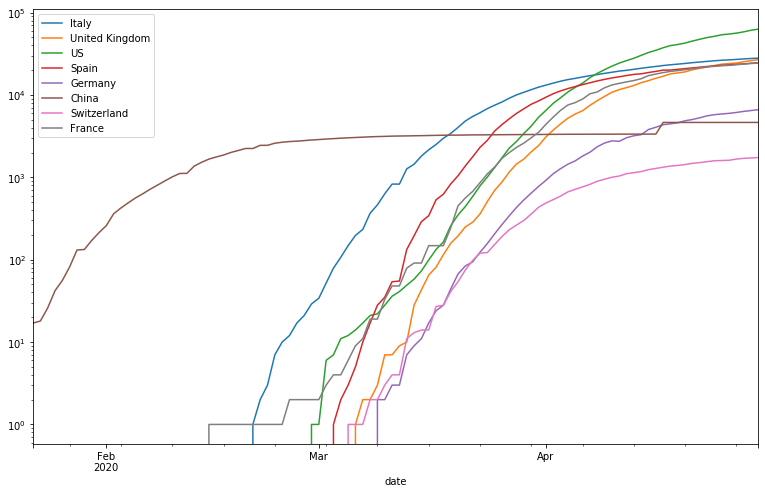

In [104]:
plot_data(comp_death, logy=True, figsize=(13, 8))

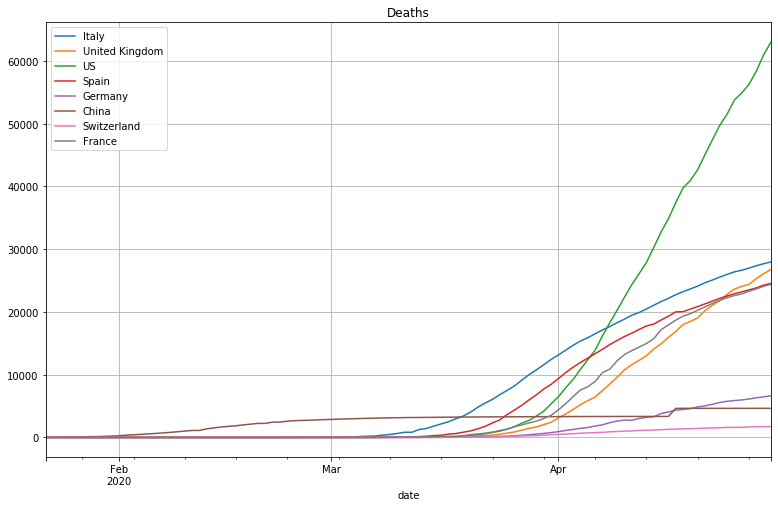

In [105]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [106]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [107]:
world_death.index = pd.to_datetime(world_death.index)

In [108]:
world_death["day_of_year"] = world_death.index.dayofyear

In [109]:
world_death.reset_index(inplace=True)

In [110]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [111]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [112]:
comp_world = pd.concat([world, world_death], axis=1)

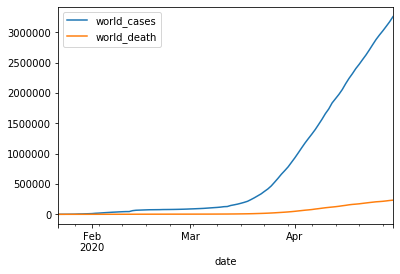

In [113]:
plot_data(comp_world)

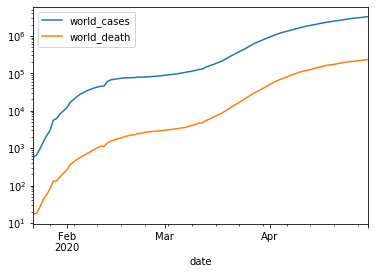

In [114]:
plot_data(comp_world, logy=True)

In [115]:
comp_world.to_excel(xl_writer, "World")

In [116]:
xl_writer.close()

In [117]:
df.columns[-1]

'4/30/20'

In [118]:
df['4/17/20']

0       906
1       539
2      2418
3       696
4        19
       ... 
261       6
262       4
263       1
264       0
265       0
Name: 4/17/20, Length: 266, dtype: int64

In [119]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [120]:
df_summary_cases.columns = ["Country", "Cases"]

In [121]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [122]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [123]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [124]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

,Unnamed: 0,Country,alpha-2
150,152,Namibia,NA


In [125]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [126]:
df_summary

,Country,Cases,Deaths,alpha-2
0,Afghanistan,2171.0,64.0,AF
1,Albania,773.0,31.0,AL
2,Algeria,4006.0,450.0,DZ
3,Andorra,745.0,42.0,AD
4,Angola,27.0,2.0,AO
...,...,...,...,...
245,Tuvalu,NaN,NaN,TV
246,U.S. Virgin Islands,NaN,NaN,VI
247,United States,NaN,NaN,US
248,Vanuatu,NaN,NaN,VU


In [127]:
df_summary.sort_values(by=["Cases",], ascending=False)

,Country,Cases,Deaths,alpha-2
173,US,1069424.0,62996.0,US
157,Spain,213435.0,24543.0,ES
85,Italy,205463.0,27967.0,IT
177,United Kingdom,172481.0,26842.0,GB
62,France,167299.0,24410.0,FR
...,...,...,...,...
245,Tuvalu,NaN,NaN,TV
246,U.S. Virgin Islands,NaN,NaN,VI
247,United States,NaN,NaN,US
248,Vanuatu,NaN,NaN,VU


In [128]:
number_of_countries = 15

In [129]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [130]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [131]:
by_countries.head(20)

,Cases,Deaths
Country,,
US,1069424.0,62996.0
Spain,213435.0,24543.0
Italy,205463.0,27967.0
United Kingdom,172481.0,26842.0
France,167299.0,24410.0
Germany,163009.0,6623.0
Turkey,120204.0,3174.0
Russia,106498.0,1073.0
Iran,94640.0,6028.0


In [132]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     2663060.0
 Deaths     211065.0
 dtype: float64]

In [133]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [134]:
by_countries

,Cases,Deaths
US,1069424.0,62996.0
Spain,213435.0,24543.0
Italy,205463.0,27967.0
United Kingdom,172481.0,26842.0
France,167299.0,24410.0
Germany,163009.0,6623.0
Turkey,120204.0,3174.0
Russia,106498.0,1073.0
Iran,94640.0,6028.0
Brazil,87187.0,6006.0


In [135]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [136]:
by_countries

,Cases,Deaths
US,1069424.0,62996.0
Spain,213435.0,24543.0
Italy,205463.0,27967.0
United Kingdom,172481.0,26842.0
France,167299.0,24410.0
Germany,163009.0,6623.0
Turkey,120204.0,3174.0
Russia,106498.0,1073.0
Iran,94640.0,6028.0
Brazil,87187.0,6006.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f394529f990>,
      dtype=object)

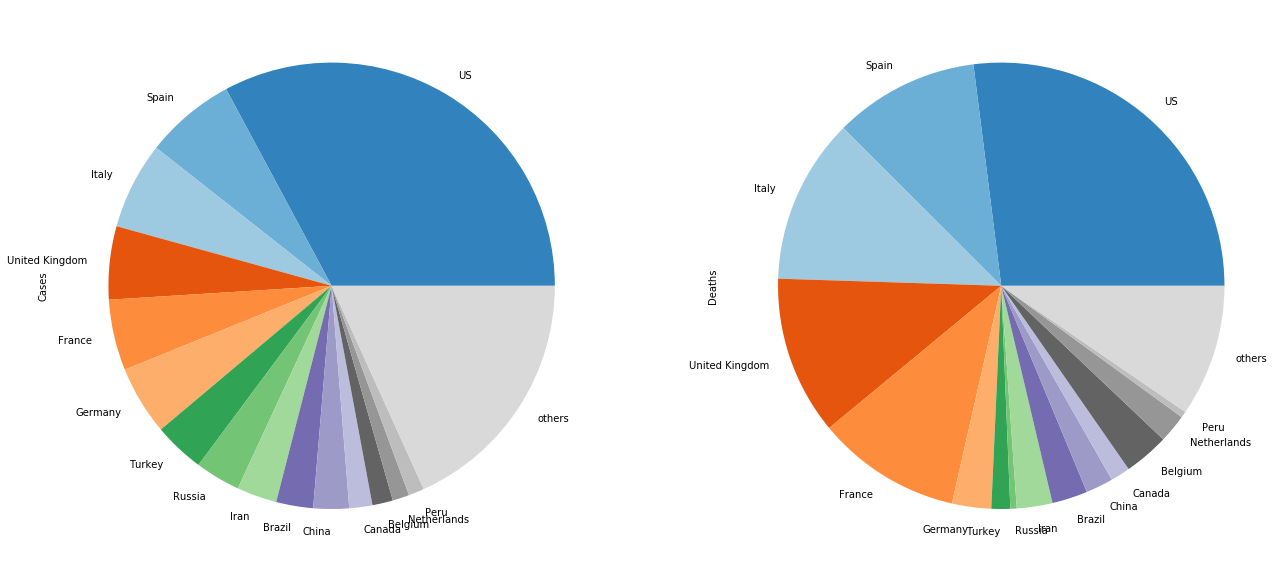

In [137]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False)

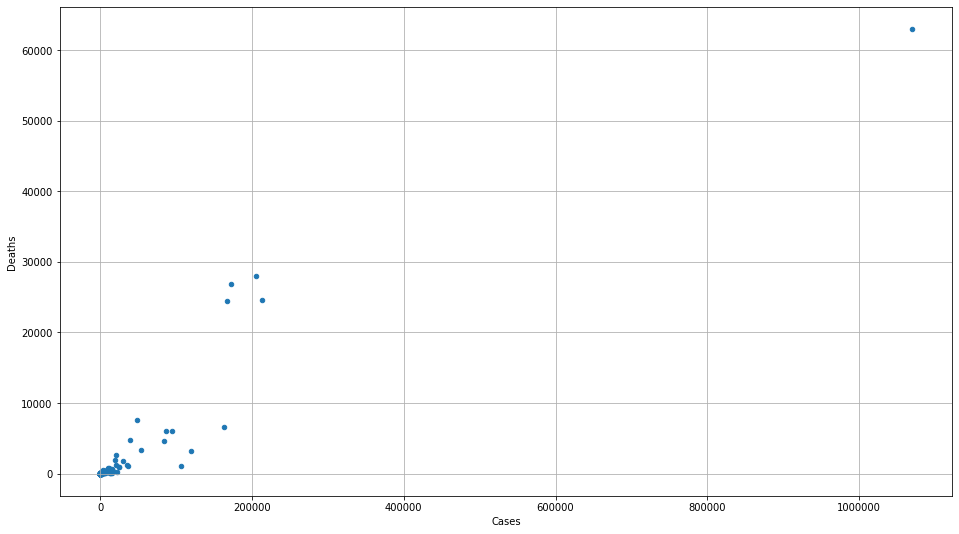

In [138]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

In [139]:
comp_world

,,world_cases,world_death
date,day_of_year,,
2020-01-22,22,555,17
2020-01-23,23,654,18
2020-01-24,24,941,26
2020-01-25,25,1434,42
2020-01-26,26,2118,56
...,...,...,...
2020-04-26,117,2955033,209931
2020-04-27,118,3023722,214515
2020-04-28,119,3097190,220830


In [140]:
comp_world["daily cases"] = comp_world["world_cases"].diff()

In [141]:
comp_world["daily deaths"] = comp_world["world_death"].diff()

In [142]:
comp_world

,,world_cases,world_death,daily cases,daily deaths
date,day_of_year,,,,
2020-01-22,22,555,17,NaN,NaN
2020-01-23,23,654,18,99,1
2020-01-24,24,941,26,287,8
2020-01-25,25,1434,42,493,16
2020-01-26,26,2118,56,684,14
...,...,...,...,...,...
2020-04-26,117,2955033,209931,73893,3713
2020-04-27,118,3023722,214515,68689,4584
2020-04-28,119,3097190,220830,73468,6315


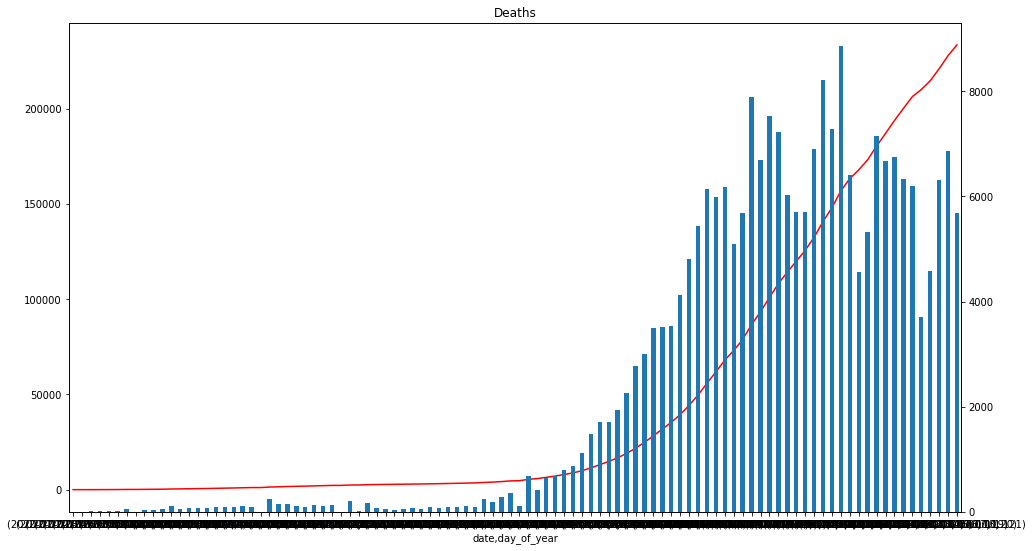

In [143]:
comp_world["world_death"].plot(figsize=(16,9), color="r", title="Deaths")
comp_world["daily deaths"].plot.bar(secondary_y=True, rot=0, figsize=(16,9))

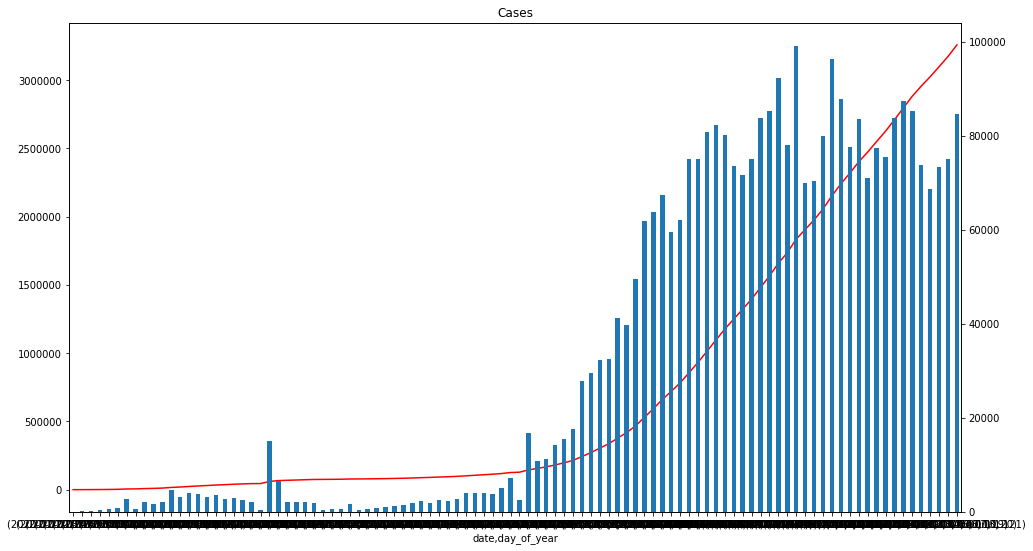

In [144]:
comp_world["world_cases"].plot(figsize=(16,9), color="r", title="Cases")
comp_world["daily cases"].plot.bar(secondary_y=True, rot=0, figsize=(16,9))

In [145]:
def add(df1, df2, country):
    df = pd.concat([extract_data(df1, country), extract_data(df2, country)], axis=1)
    df.columns = ["Cases", "Deaths"]
    return df

In [146]:
se = add(df, death, "Sweden")

In [147]:
uk = add(df, death, "United Kingdom")

In [148]:
it = add(df, death, "Italy")

In [149]:
sp = add(df, death, "Spain")

In [150]:
fr = add(df, death, "France")

In [151]:
ch = add(df, death, "Switzerland")

In [152]:
be = add(df, death, "Belgium")

In [153]:
de = add(df, death, "Germany")

In [154]:
kr = add(df, death, "Korea, South")

In [155]:
nl = add(df, death, "Netherland")

In [156]:
us = add(df, death, "US")

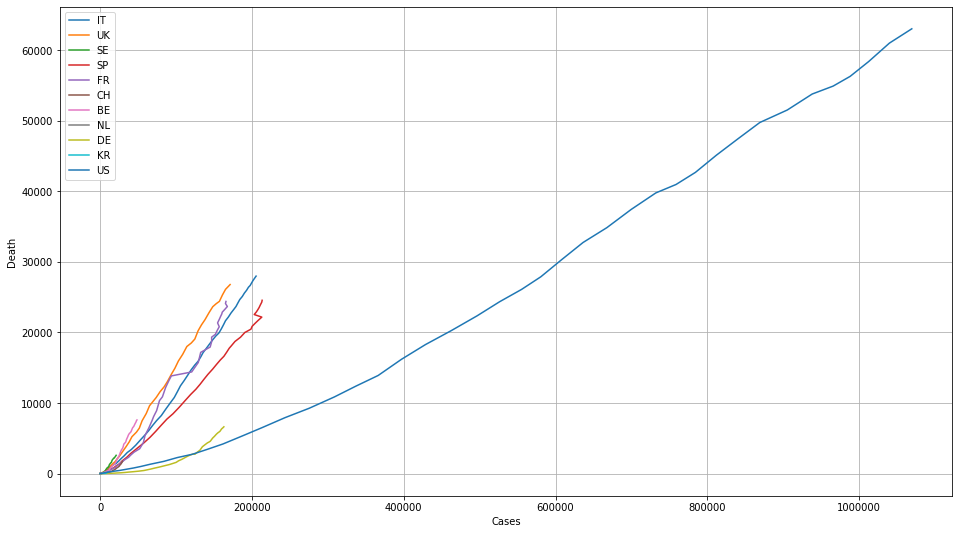

In [157]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="IT")
uk.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="UK")
se.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="SE")
sp.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="SP")
fr.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="FR")
ch.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="CH")
be.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="BE")
nl.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="NL")
de.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="DE")
kr.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="KR")
us.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="US")

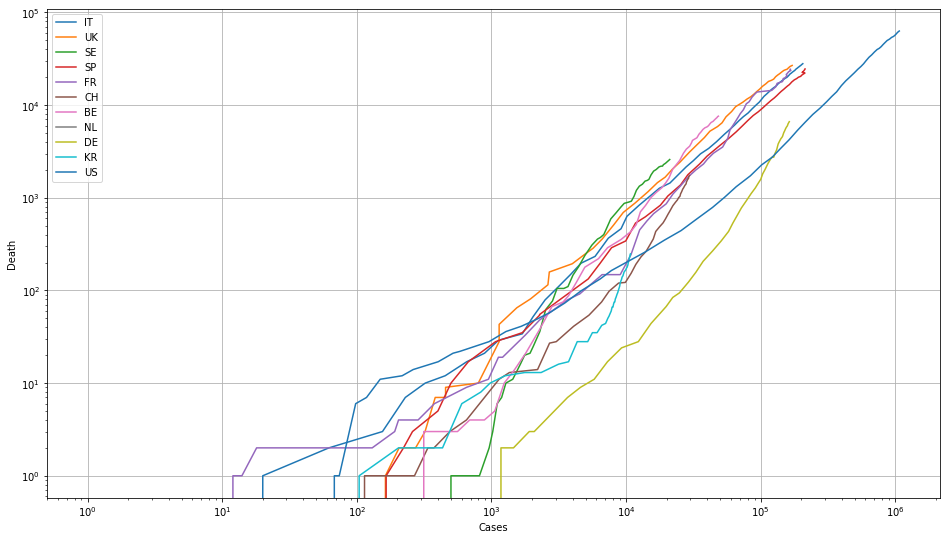

In [158]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="IT", loglog=True)
uk.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="UK")
se.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="SE")
sp.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="SP")
fr.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="FR")
ch.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="CH")
be.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="BE")
nl.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="NL")
de.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="DE")
kr.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="KR")
us.plot(x="Cases", y="Deaths", ax=ax, grid=True, label="US")

In [159]:
by_countries.index

Index(['US', 'Spain', 'Italy', 'United Kingdom', 'France', 'Germany', 'Turkey',
       'Russia', 'Iran', 'Brazil', 'China', 'Canada', 'Belgium', 'Netherlands',
       'Peru', 'others'],
      dtype='object')